In [120]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from PIL import Image
from google.colab import drive

In [121]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ensure TensorFlow Version
#!pip install --upgrade tensorflow
#assert tf.__version__ >= "2.18.0", "TensorFlow version must be 2.8.0 or higher."

In [122]:

# Set default font sizes for matplotlib
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [123]:
# Load metadata
metadata = pd.read_csv("/content/drive/My Drive/images/HAM10000_metadata.csv")

# Define paths to the two image directories
image_dir_part1 = "/content/drive/My Drive/images/HAM10000_images_part_1"
image_dir_part2 = "/content/drive/My Drive/images/HAM10000_images_part_2"


In [124]:
# Add 'image_path' column
metadata["image_path"] = metadata["image_id"].apply(
    lambda x: os.path.join(image_dir_part1, f"{x}.jpg")
    if os.path.exists(os.path.join(image_dir_part1, f"{x}.jpg"))
    else os.path.join(image_dir_part2, f"{x}.jpg")
)

In [125]:
# Filter rows with missing image files
metadata = metadata[metadata["image_path"].apply(os.path.exists)]
print(f"Number of valid images: {len(metadata)}")

Number of valid images: 7103


In [127]:

# Split metadata into training and validation sets
train_df = metadata.sample(frac=0.8, random_state=42)  # 80% training data
val_df = metadata.drop(train_df.index)  # Use the remaining rows for validation

# Reset the indices for both DataFrames after splitting
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Verify the split
print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")


Training set: 5682 images
Validation set: 1421 images


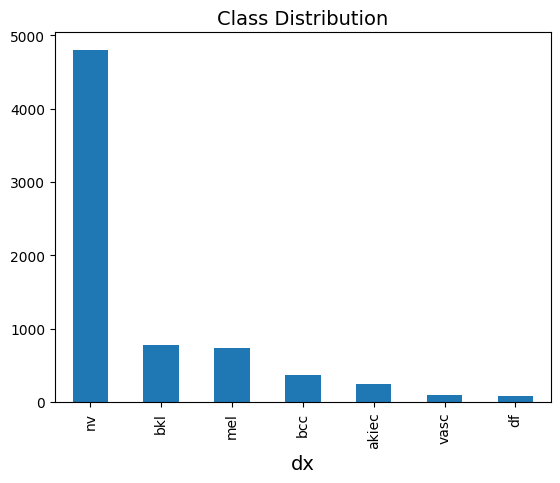

In [128]:
# Visualization - Class Distribution
metadata["dx"].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

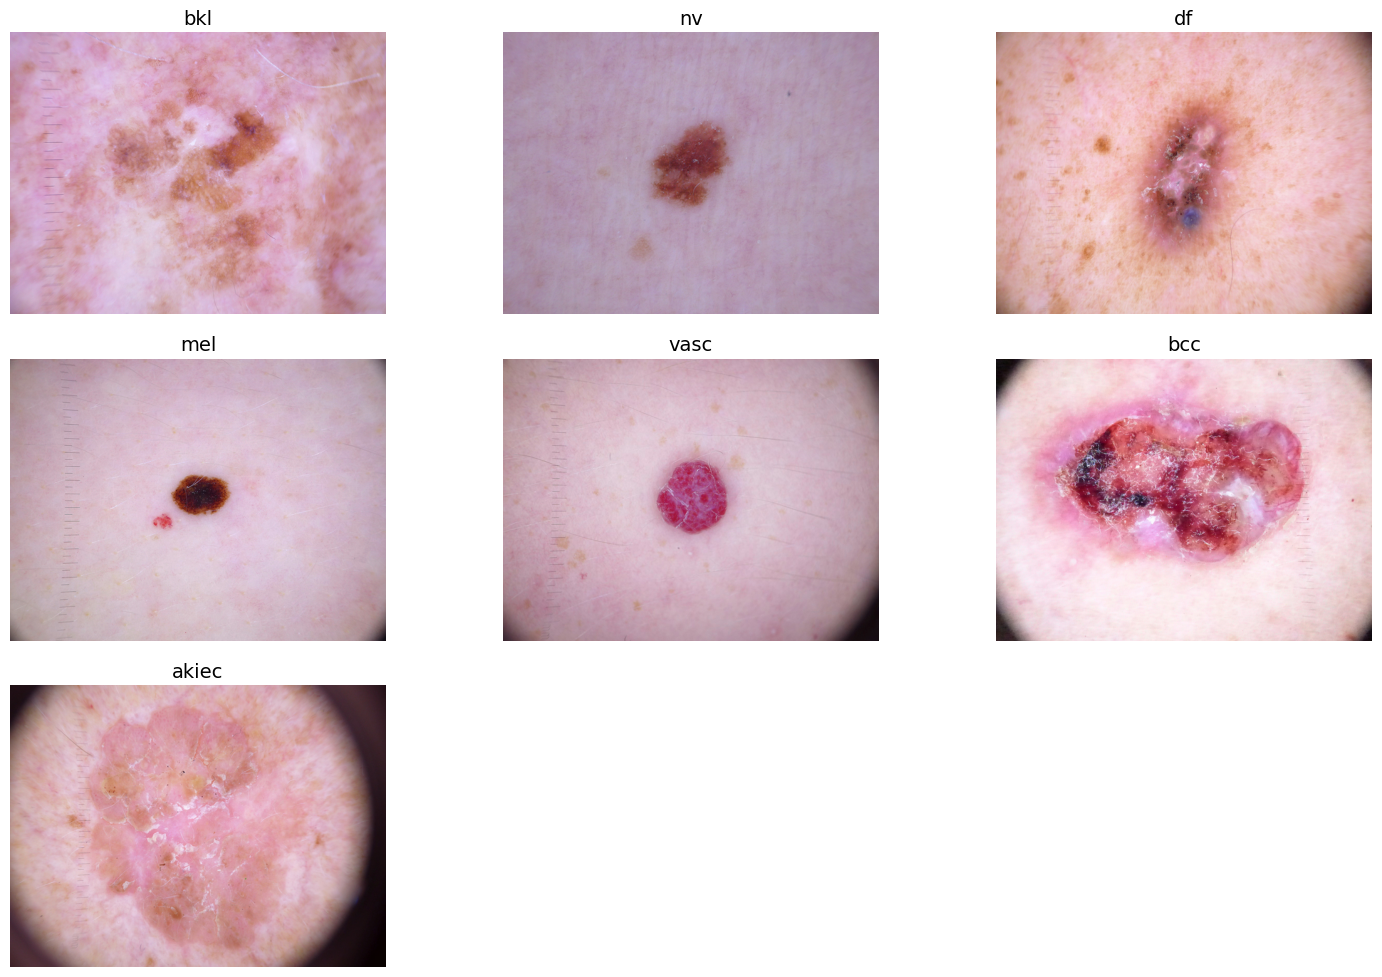

In [129]:
# Display sample images by class
classes = metadata["dx"].unique()
plt.figure(figsize=(15, 10))
for i, cls in enumerate(classes):
    sample = metadata[metadata["dx"] == cls].iloc[0]["image_path"]
    img = mpimg.imread(sample)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.tight_layout()
plt.show()

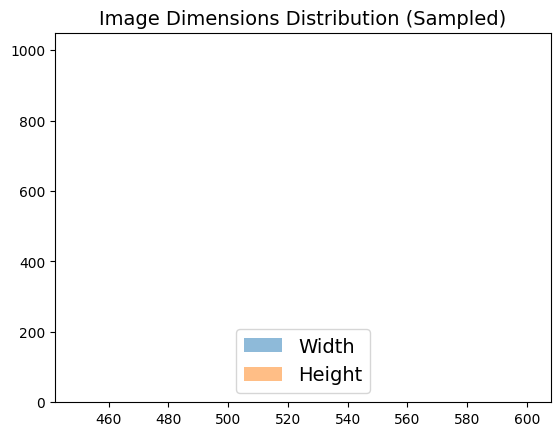

In [130]:
# Image Size Distribution
sizes = [Image.open(path).size for path in metadata["image_path"][:1000]]
widths, heights = zip(*sizes)
plt.hist(widths, bins=20, alpha=0.5, label="Width")
plt.hist(heights, bins=20, alpha=0.5, label="Height")
plt.legend()
plt.title("Image Dimensions Distribution (Sampled)")
plt.show()

In [131]:
# Data Augmentation and Normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1.0/255)

In [132]:


# Create Data Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="dx",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="dx",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)

Found 5682 validated image filenames belonging to 7 classes.
Found 1421 validated image filenames belonging to 7 classes.


In [133]:


# Verify Data Generators
x_batch, y_batch = next(train_generator)
print(f"Image batch shape: {x_batch.shape}")
print(f"Label batch shape: {y_batch.shape}")

Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 7)


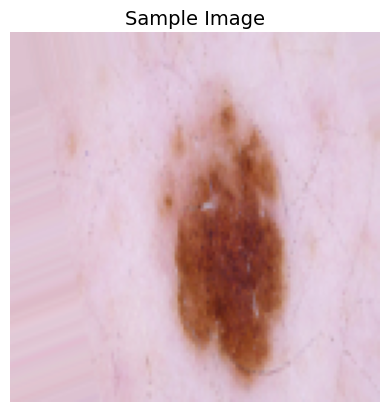

In [134]:

# Display the first image from the batch
plt.imshow(x_batch[0])
plt.axis('off')
plt.title("Sample Image")
plt.show()

# **CNN Architecture**

In [135]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,393,223 (28.20 MB)

 Trainable params: 7,393,223 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [136]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [137]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Start with 10-20 epochs
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 690s 4s/step - accuracy: 0.6243 - loss: 1.4407 - val_accuracy: 0.6925 - val_loss: 1.0393
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.6781 - loss: 1.0169 - val_accuracy: 0.6925 - val_loss: 0.9446
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.6641 - loss: 0.9788 - val_accuracy: 0.6925 - val_loss: 0.9616
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.6774 - loss: 0.9342 - val_accuracy: 0.6925 - val_loss: 0.8893
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.6677 - loss: 0.9094 - val_accuracy: 0.6932 - val_loss: 0.8862
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.6724 - loss: 0.8906 - val_accuracy: 0.6932 - val_loss: 0.8675
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.6692 - loss: 0.8832 - val_accuracy: 0.6939 - val_loss: 0.8372
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.6896 - loss: 0.8395 - val_accuracy: 0.693

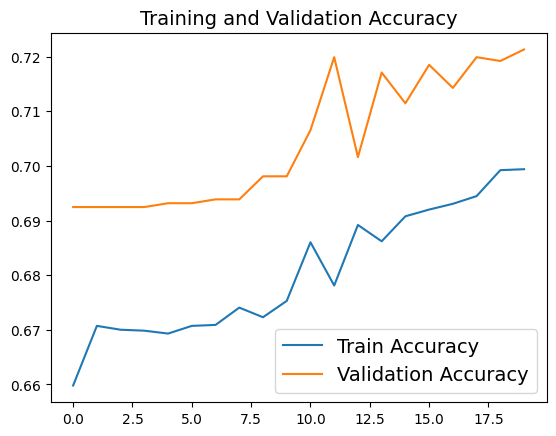

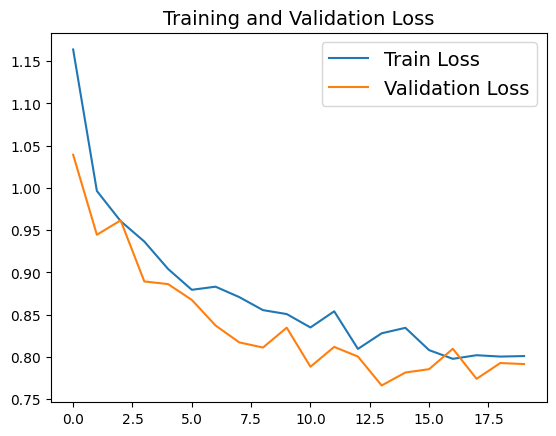

In [138]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [139]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")


45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 642ms/step - accuracy: 0.7173 - loss: 0.7760
Validation Loss: 0.7915573120117188
Validation Accuracy: 0.7213230133056641


In [140]:
model.save('skin_mole_cnn_model.h5')


In [143]:
model.save('/content/drive/My Drive/my_model.keras')  # Save in your Google Drive


In [144]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load the pretrained CNN (VGG16 without top layers for feature extraction)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Data generator for feature extraction
datagen = ImageDataGenerator(rescale=1.0/255)

# Extract features for training set
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="dx",
    target_size=(128, 128),
    batch_size=32,
    class_mode=None,
    shuffle=False  # Ensure the order matches labels
)

train_features = vgg_model.predict(train_generator)
train_features = train_features.reshape(train_features.shape[0], -1)  # Flatten features

# Extract features for validation set
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="dx",
    target_size=(128, 128),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

val_features = vgg_model.predict(val_generator)
val_features = val_features.reshape(val_features.shape[0], -1)  # Flatten features

# Encode labels into numerical format
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df["dx"])
val_labels = label_encoder.transform(val_df["dx"])

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

# Train the SVM classifier
svm = SVC(kernel='linear', probability=True)  # Use linear kernel
svm.fit(train_features, train_labels)

# Make predictions
val_predictions = svm.predict(val_features)

# Evaluate the model
print("SVM Classification Report:")
print(classification_report(val_labels, val_predictions, target_names=label_encoder.classes_))

# Calculate accuracy
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 5682 validated image filenames.
178/178 ━━━━━━━━━━━━━━━━━━━━ 1270s 7s/step
Found 1421 validated image filenames.
45/45 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step
SVM Classification Report:
              precision    recall  f1-score   support

       akiec       0.29      0.31      0.30        48
         bcc       0.47      0.36      0.41        78
         bkl       0.33      0.42      0.37       136
          df       0.28      0.31      0.29        16
         mel       0.38      0.41      0.40       132
          nv       0.87      0.85      0.86       984
        vasc       0.74      0.52      0.61        27

    accuracy                           0.71      1421
   macro avg       0.48      0.45      0.46      1421
weighted avg       0.72      0.71      0.72      1421

Validation Accuracy: 0.71
